In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import scipy.stats as stats
import tensorflow as tf
from fkan.tensorflow import FractionalJacobiNeuralBlock as fJNB
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *

plt.style.use("science")

In [2]:
class SaveWeightsCallback(tf.keras.callbacks.Callback):
    def __init__(self, filename):
        super(SaveWeightsCallback, self).__init__()
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        weights = tuple(
            np.array(
                self.get_layer_by_keyword(
                    "fractional_jacobi_neural_block"
                ).get_weights()
            ).flatten()
        )
        with open(self.filename, "a") as file:
            file.write("%f,%f,%f\n" % weights)

    def get_layer_by_keyword(self, keyword):
        for layer in self.model.layers:
            if keyword in layer.name:
                return layer
        return None

data shape: (250, 1) (250,)


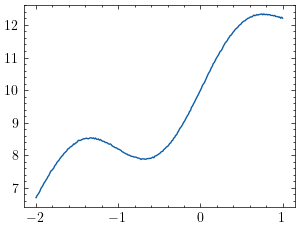

In [3]:
def f(x):
    return np.sin(x * np.pi) + 10 * np.exp(x / 5) + np.random.randn(len(x)) * 0.01


a, b = -2, 1

t = np.linspace(a, b, 250)
y = f(t)

X = t.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0
)

print("data shape:", X.shape, y.shape)
plt.plot(t, y)

If using a predefined Keras activation function, replace each `fJNB(q)` with: `layers.Activation(activation)`

In [4]:
MAE = []
for trial in range(1):
    tf.random.set_seed(trial)
    np.random.seed(trial)

    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(Dense(5))
    model.add(fJNB(5))
    model.add(Dense(1))

    opt = optimizers.Adam(learning_rate=0.01)
    loss = tf.keras.losses.MeanSquaredError(name="loss")

    model.compile(optimizer=opt, loss=loss, metrics=["mae"])

    save_weights_callback = SaveWeightsCallback("data/weights/weights-%d.txt" % trial)

    params = dict(
        epochs=500,
        batch_size=1000,
        verbose=0,
        validation_split=0.2,
        callbacks=[save_weights_callback],
    )

    history = model.fit(X_train, y_train, **params)

    p = model.predict(X_test, verbose=0).flatten()
    mae_test = tf.keras.losses.mean_absolute_error(y_test, p).numpy()
    print(trial, mae_test)
    MAE.append(mae_test)

MAE = np.array(MAE)
np.savetxt("data/weights/MAE.txt", MAE)

0 0.21654092


In [5]:
MAE = np.loadtxt("data/weights/MAE.txt")
files = sorted(glob.glob("data/weights/weights-*.txt"))
weights = []
for file in files:
    trial = int(file[len("data/weights/") + 8 : -4])
    if MAE[trial] < 0.10:
        weights.append(np.loadtxt(file, delimiter=","))

weights = np.array(weights)
weights.shape

(11, 500, 3)

In [6]:
mean = weights.mean(axis=0)
var = weights.var(axis=0)

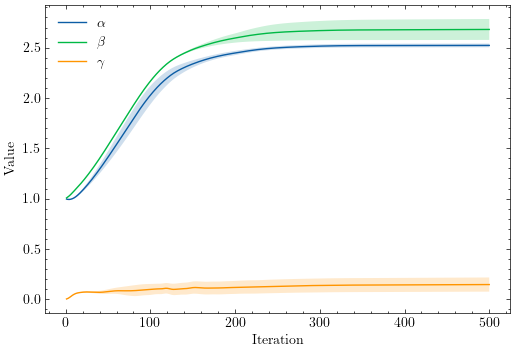

In [7]:
x = list(range(1, 1 + len(mean)))
labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(3):
    ax.plot(x, mean[:, i], label=labels[i])
    ax.fill_between(x, mean[:, i] - var[:, i], mean[:, i] + var[:, i], alpha=0.2)
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Value")
fig.savefig("values-alpha-beta-gamma.png", bbox_inches="tight")